# Load and data exploration


In [49]:
import pandas as pd  
import folium
from folium import plugins
import numpy as np  
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import mpu
import warnings
warnings.filterwarnings("ignore")
sns.set()

# Load with Pandas

In [2]:
raw_pd = pd.read_csv('../data/raw/routes.csv', delimiter='\t')

# Drop NaN

As shown below, the amount of `NaN` values is less than **1%**, so might as well drop them for starters.

In [3]:
nan_pd = raw_pd[raw_pd.isna().any(axis=1)]

In [4]:
null_pd = raw_pd[raw_pd.isnull().any(axis=1)]

In [5]:
len(nan_pd), len(null_pd), len(raw_pd)

(9198, 9198, 2045260)

In [6]:
nan_pd.index.to_list() == null_pd.index.to_list()

True

In [7]:
len(nan_pd)/len(raw_pd)

0.004497227736326922

In [8]:
raw_pd = raw_pd.dropna()
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)


# Exploration

Lets explore some basic metrics of the dataset

## Locations

Lets see the location data plotted. There are a few of trips outside the city, but it is hard to decide where the boundaries of the city are without getting involved. We could decided an acceptable box of the city limits and drop trips with both `source` and `destinations` outside that box.

In [9]:
# Coordinate box of all trips
bbox = (
    min(raw_pd.source_longitude.min(), raw_pd.destination_longitude.min()), 
    max(raw_pd.source_longitude.max(), raw_pd.destination_longitude.max()),
    min(raw_pd.source_latitude.min(), raw_pd.destination_latitude.min()), 
    max(raw_pd.source_latitude.max(), raw_pd.destination_latitude.max())
)
bbox

(-77.195267, -76.46822900000001, -13.030456, -11.75353)

<IPython.core.display.Javascript object>


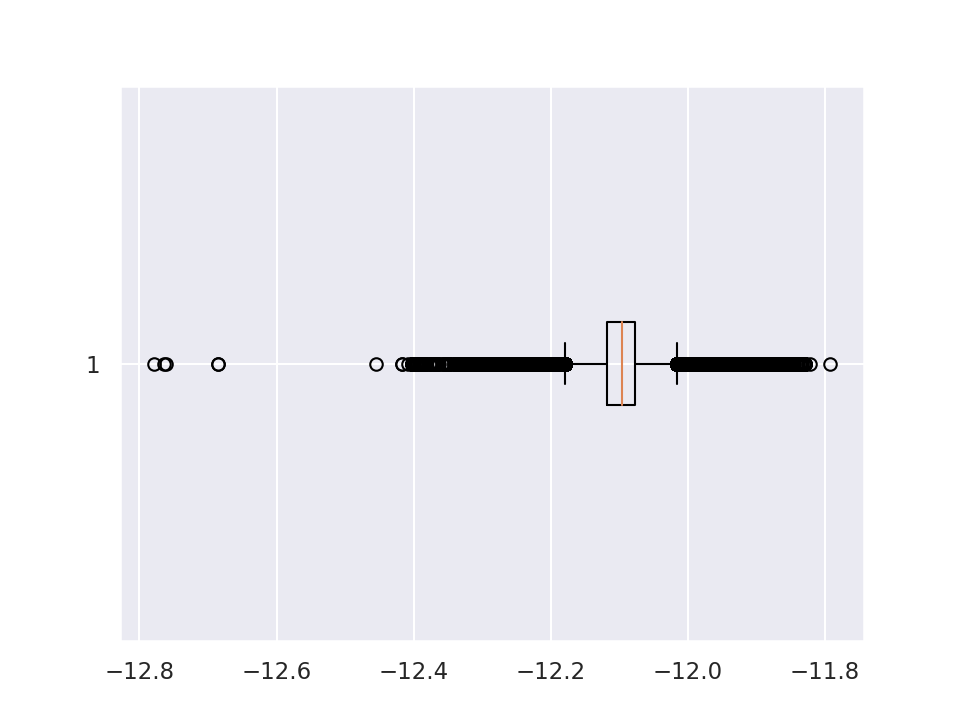

In [10]:
# View of lat, long locations 
plt.boxplot(raw_pd.source_latitude, vert=False)
plt.show()


<IPython.core.display.Javascript object>


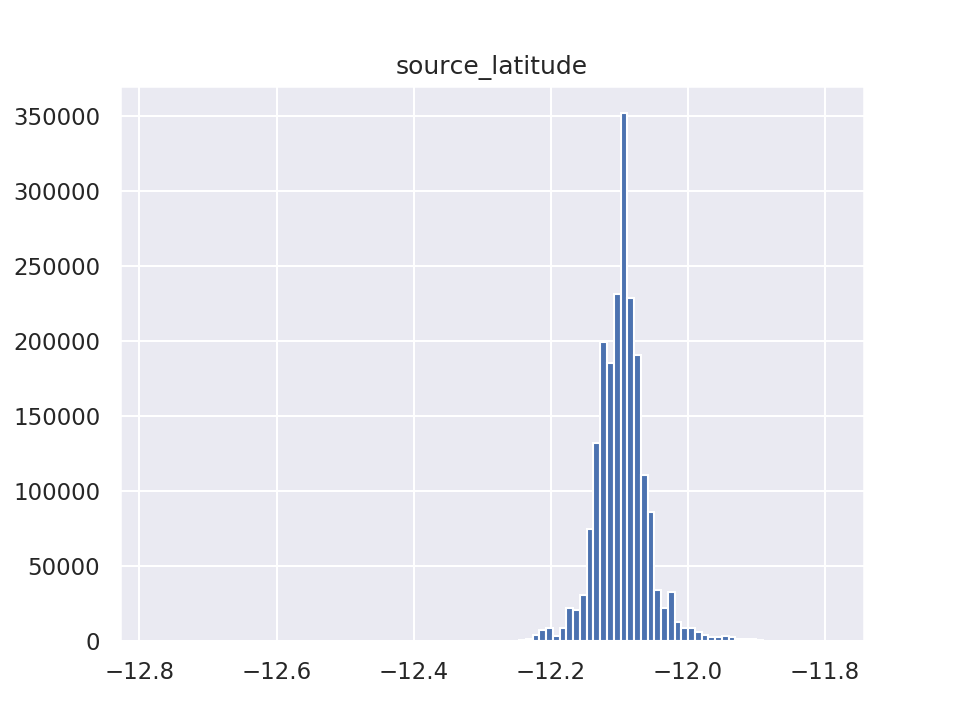

In [11]:
raw_pd.hist('source_latitude', bins=100)
plt.show()

<IPython.core.display.Javascript object>


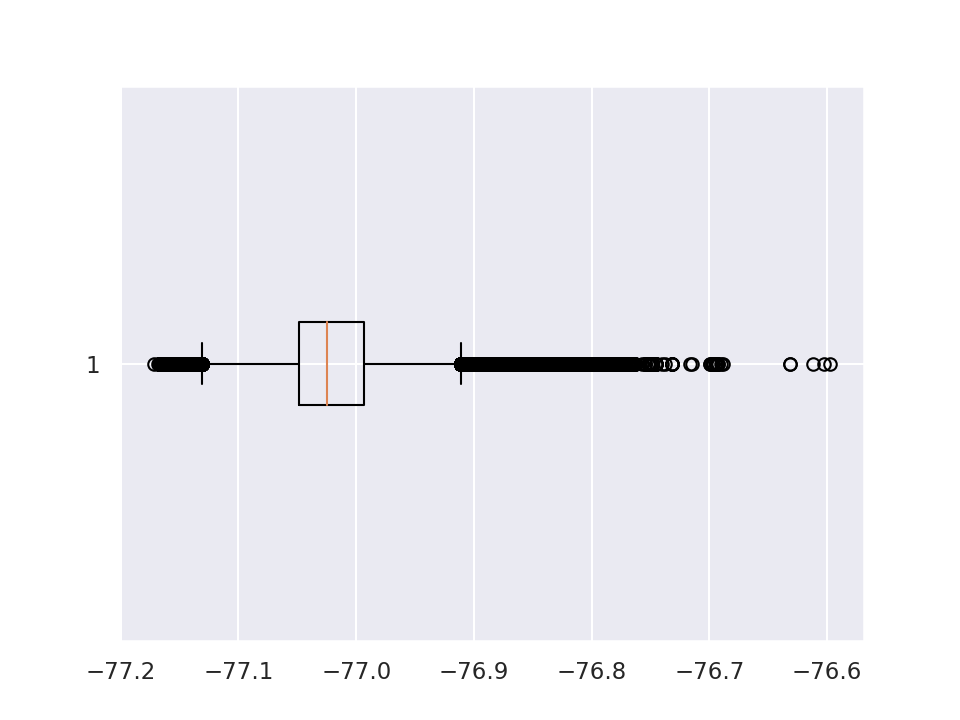

In [12]:
plt.boxplot(raw_pd.source_longitude, vert=False)
plt.show()

<IPython.core.display.Javascript object>


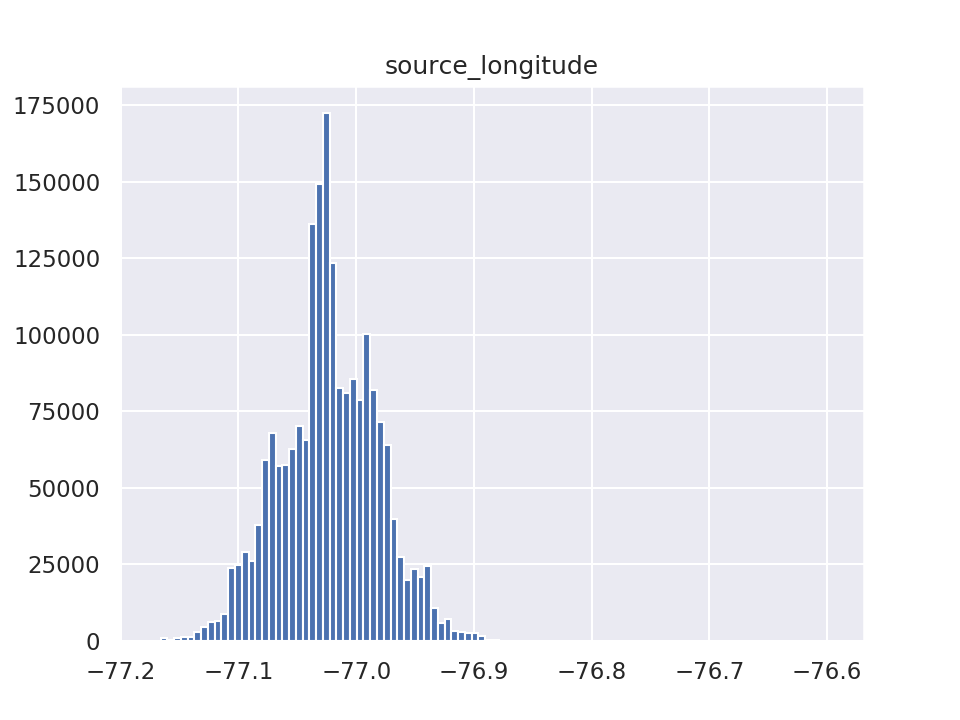

In [13]:
raw_pd.hist('source_longitude', bins=100)
plt.show()

In [14]:
# Time period of data
raw_pd.request_date.max() - raw_pd.request_date.min()

Timedelta('120 days 23:59:56')

In [15]:
# Number of source addresses involved
len(set(raw_pd.source_address))

317873

In [16]:
# Number of destination addresses
len(set(raw_pd.destination_address))

201128

In [17]:
# Number of total addresses
len(set(
    raw_pd.source_address.to_list() + raw_pd.destination_address.to_list()
))

414756

### Matplotlib locations eyeballing



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


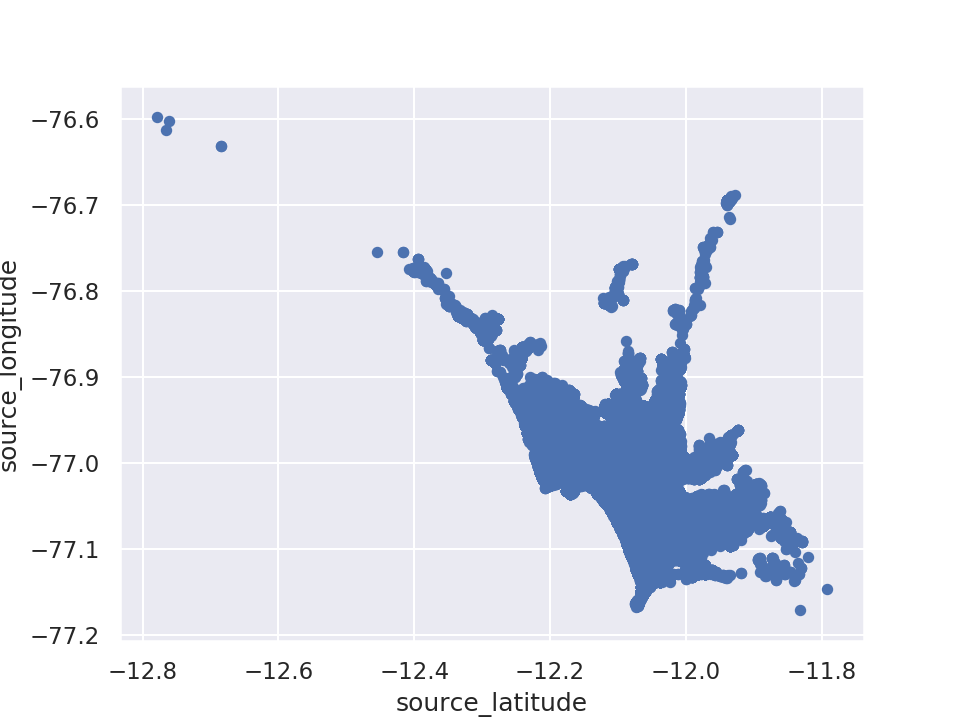

In [18]:
raw_pd.plot(x='source_latitude', y='source_longitude', kind='scatter')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<IPython.core.display.Javascript object>


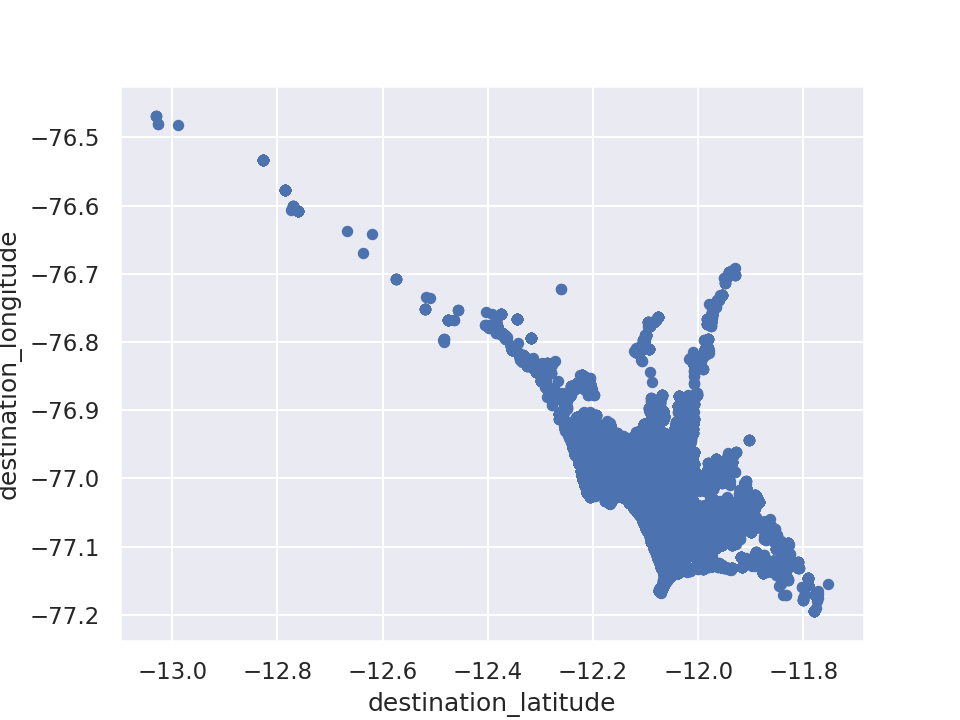

In [19]:
raw_pd.plot(x='destination_latitude', y='destination_longitude', kind='scatter')
plt.show()

### Folium sample locations eyeballing

A quick glance at a sample with a map background and comparison with previous scatterplots, let's us know that the dataset is pretty much in the right city and also on land. It would become quite involed to check if every point is not in the water, including a GPS error margin, so we will stick to just looking and comparing by eye for now.

In [20]:
src_lat_mean = raw_pd['source_latitude'].mean()
src_lon_mean = raw_pd['source_longitude'].mean()

In [21]:
src_latlon_pd = raw_pd[['source_latitude', 'source_longitude']] 

In [22]:
coords = [
    [lat, lon] 
    for lat, lon in zip(
        src_latlon_pd.source_latitude[0:10000], 
        src_latlon_pd.source_longitude[0:10000]
    )
]


In [23]:
map = folium.Map(location=[src_lat_mean, src_lon_mean])
map.add_child(plugins.FastMarkerCluster(coords[0:10000]))
map

### Trips outside the city

In [24]:
trips_outside_the_city = raw_pd[
    (raw_pd['source_latitude'] > -12.3) & (raw_pd['source_longitude'] > -76.8 )
    &
    (raw_pd['destination_latitude'] > -12.3) & (raw_pd['destination_longitude'] > -76.8 )

]
len(trips_outside_the_city)

6

## Trip counts


Trip counts per hour is the meat of this project. Let's group by `passenger_id`, `source_address` and `destination_address` and combinations of them and count the number of trips. The object is to get a better idea of the dataset. 

The results for the **~121 days** of trips are as follows:

In [25]:
data = raw_pd
data['trip_count'] = 1

In [26]:
# Number of trips
len(raw_pd)

2036062

<IPython.core.display.Javascript object>


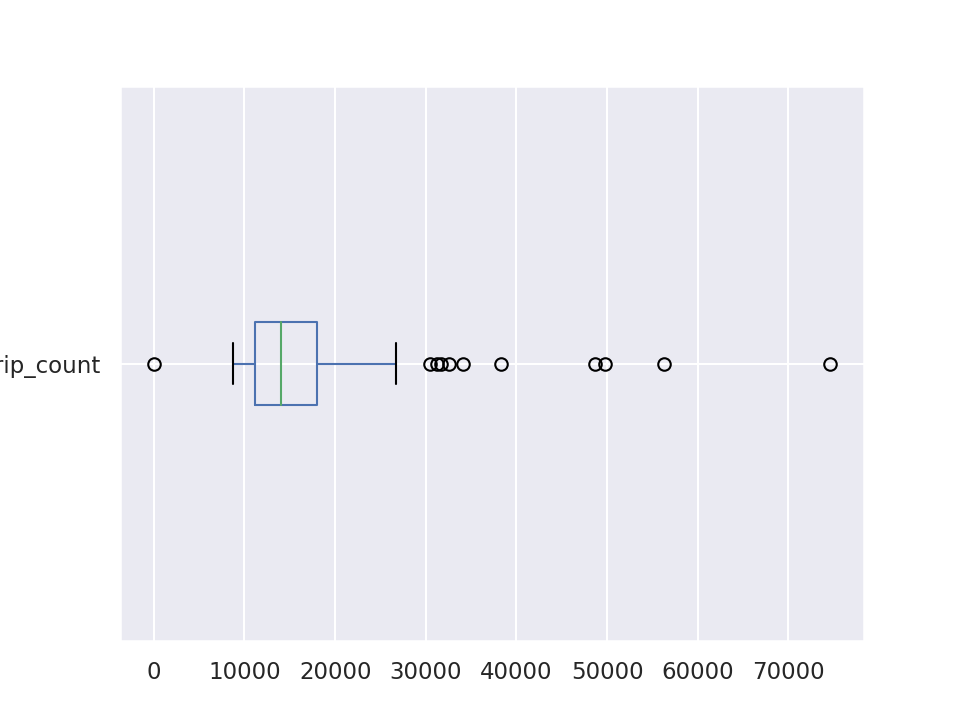

In [45]:

# Lets see the trips per day
trips_per_day = data.groupby(data.request_date.dt.dayofyear).count()[['trip_count']]
trips_per_day.boxplot(vert=False)
plt.show()

<IPython.core.display.Javascript object>


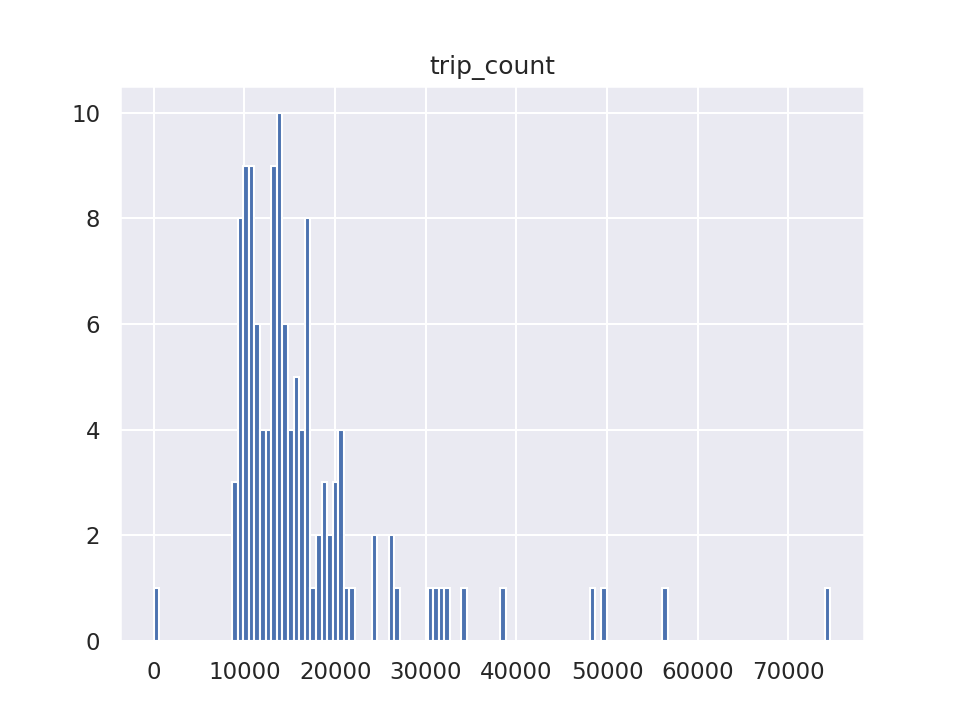

In [48]:
trips_per_day.hist(bins=121)
plt.show()

### Passengers

It is strange that the same `passenger id`'s have performed  thousands of trips on only 122 days. Next we will see that the same `passenger_id`'s performed thousands of trips to and from the same locations.

In [27]:
data.groupby(
    by=[
        data.passenger_id,
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,trip_count
passenger_id,
76772,1752
188719,1499
124189,1289


In [28]:
data.groupby(
    by=[
        data.passenger_id,
        data.source_address,
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,,trip_count
passenger_id,source_address,
124189,"Calle Nazcas 136, San Miguel 32",1068
76772,"Jirón Leoncio Prado 363, Magdalena del Mar 17",948
77779,"Avenida Brasil 3739, Magdalena del Mar 17",921


In [29]:
data.groupby(
    by=[
        data.passenger_id,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,,trip_count
passenger_id,destination_address,
76772,"Av. Canaval y Moreyra 522, San Isidro 27",1070
124189,"Plaza 30 de Agosto s/n, , San Isidro",1063
77779,"Calle 28 176, San Isidro 27",914


In [30]:
# Lets see how many of the 100 most popular destinations are also in the 100 most popular sources.
top100_sources = data.groupby(
    by=[
        data.source_address,
#         data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(100).reset_index()

top100_destinations = data.groupby(
    by=[
#         data.source_address,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(100).reset_index()


len(top100_destinations.merge(top100_sources, left_on='destination_address', right_on='source_address'))

30

### Grouping by both source and destination (entire trip)

This is the most difficult part to make sense of, while having the same source and destination addresses for thousands of times might be excusable for popular taxi piazzas, it does not make sense for the same `passenger_id` to be conducting most of these trips, or for not also seeing the same trend with source and destination addreses reversed.

In [31]:
# Top three trips (both source and destination)

data.groupby(
    by=[
        data.source_address,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,,trip_count
source_address,destination_address,
"Calle Nazcas 136, San Miguel 32","Plaza 30 de Agosto s/n, , San Isidro",1072
"Avenida Brasil 3739, Magdalena del Mar 17","Calle 28 176, San Isidro 27",914
"Jirón Leoncio Prado 363, Magdalena del Mar 17","Av. Canaval y Moreyra 522, San Isidro 27",833


In [32]:
# Top three trips with the same passenger_id are the same 3 as top three trips in general
data.groupby(
    by=[
        data.passenger_id,
        data.source_address,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,,,trip_count
passenger_id,source_address,destination_address,
124189,"Calle Nazcas 136, San Miguel 32","Plaza 30 de Agosto s/n, , San Isidro",1063
77779,"Avenida Brasil 3739, Magdalena del Mar 17","Calle 28 176, San Isidro 27",914
76772,"Jirón Leoncio Prado 363, Magdalena del Mar 17","Av. Canaval y Moreyra 522, San Isidro 27",833


In [33]:
### Lets see that top trips are not popular when reversing src and dst addresses.
# Only 5 out of the 100 most common trips happen to the other direction.

top100_trips =data.groupby(
    by=[
        data.source_address,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(100).reset_index()

top100_trips.merge(top100_trips,left_on='destination_address', right_on='source_address')

,source_address_x,destination_address_x,trip_count_x,source_address_y,destination_address_y,trip_count_y
0,"Al Monte Umbroso 209, Santiago de Surco 33","Calle Esquilache 236, San Isidro 27",532,"Calle Esquilache 236, San Isidro 27","Al Monte Umbroso 209, Santiago de Surco 33",258
1,"Calle Cohen 137, Santiago de Surco 33","Avenida Paseo de la República 3713, San Isidro 27",471,"Avenida Paseo de la República 3713, San Isidro 27","Calle Cohen 137, Santiago de Surco 33",457
2,"Avenida Paseo de la República 3713, San Isidro 27","Calle Cohen 137, Santiago de Surco 33",457,"Calle Cohen 137, Santiago de Surco 33","Avenida Paseo de la República 3713, San Isidro 27",471
3,"Av. Paseo de la Republica 3866, San Isidro 27","Calle Cohen 137, Santiago de Surco 33",384,"Calle Cohen 137, Santiago de Surco 33","Avenida Paseo de la República 3713, San Isidro 27",471
4,"Calle Esquilache 236, San Isidro 27","Al Monte Umbroso 209, Santiago de Surco 33",258,"Al Monte Umbroso 209, Santiago de Surco 33","Calle Esquilache 236, San Isidro 27",532


### Adding the day of year in the mix

Results in houndreds of trips in the same day to and from the same locations

In [34]:
data.groupby(
    by=[
        data.passenger_id,
        data.source_address,
        data.request_date.dt.dayofyear,
        data.destination_address
    ]
).count()[['trip_count']].sort_values('trip_count', ascending=False).head(3)

,,,,trip_count
passenger_id,source_address,request_date,destination_address,
267059,Av Nestor Gambeta cdra 3,358,"Calle Los Zorzales 154, Callao 1",213
265760,"Avenida República de Panamá 3030, San Isidro 27",358,"Bellavista, Callao, Callao",197
232391,"Avenida Los Eucaliptos 1244, Santa Anita 43",359,"Psaje. El Sol 397, El Callao",186


## Findings on trip counts

It it seems that thousands of trips are to and from the same addresses. This is normal, as perhaps these addresses are popular venues. Hundrends of these trips are on the same day, which is also normal for big events. We have also seen that 30 out of 100 most popular destinations are also in the top 100 sources of trips.

What is peculiar is that the same  ids were found to start and finish their rides on the same addresses for thousands of times. These where often some of the most popular trips (source and destination always the same), but where not popular when the trip was reversed.

As we do not have any context on the data, it is hard to make assumptions on the above findings. Perhaps coupons are given for particular trips, and the `passenger_id` we see is actually the coupon id. Perhaps the `passenger_id` represents the driver of the taxi. In any case no changes on the dataset will be made and all data will be considered valid.

### Trip distance

In [35]:
data = raw_pd


In [36]:
import mpu
data['distance'] = data.apply(lambda x: 
    mpu.haversine_distance(
        (x['source_latitude'], x['source_longitude']), 
        (x['destination_latitude'], x['destination_longitude'])
    ),
    axis=1
)

<IPython.core.display.Javascript object>


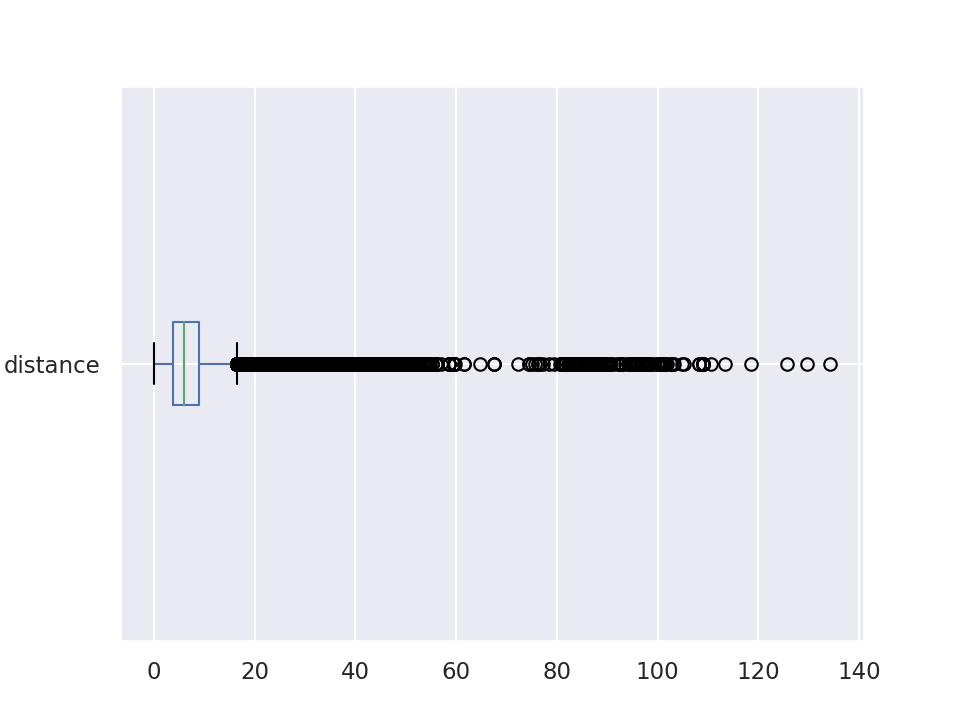

In [37]:
data.boxplot('distance', vert=False)
plt.show()

<IPython.core.display.Javascript object>


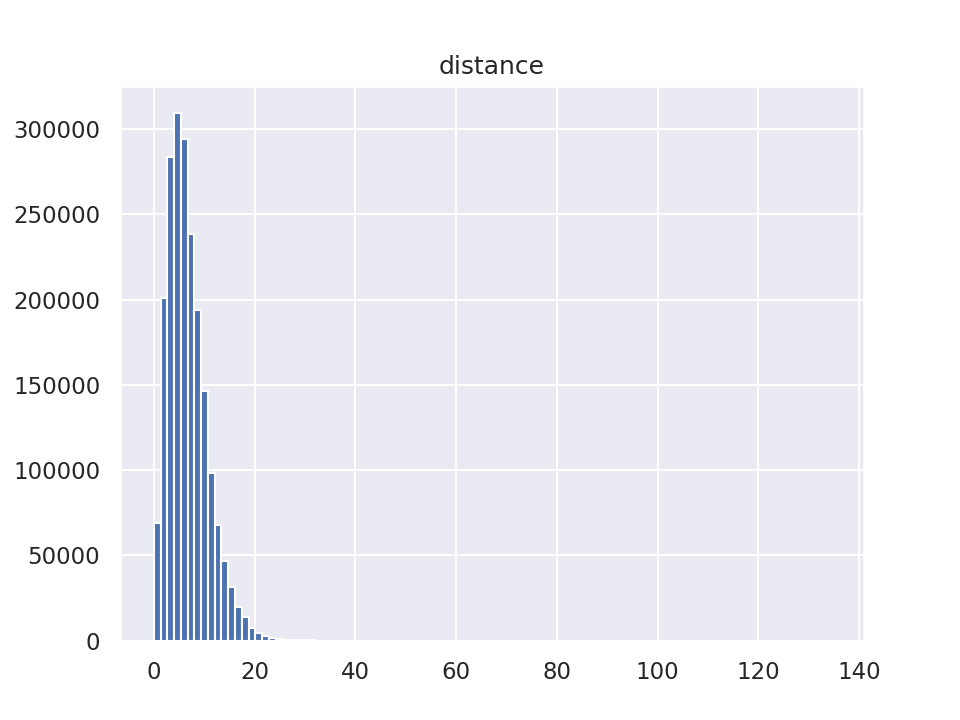

In [38]:
data.hist(column='distance', bins=100)
plt.show()

# Conclusion

We loaded the data, checked it's validity and manipulated them in several simple ways in order to explore them. This has led to some interesting questions and some ideas on outlier removal in the next section.